In [1]:
import pandas as pd
from database import Database
import matplotlib.pyplot as plt
import seaborn as sns


def similarity_score(df1, df2):
    """
    Input:
    df1 must be the one with the brands to evaluate.
    df2 must be the datafranme with the exemplars -environment or luxury
    Output: dictionary with keys: brands and values: similarity perceptual score with a dimension
    """
    if not (isinstance(df1, pd.core.frame.DataFrame) and isinstance(df2, pd.core.frame.DataFrame)):
        raise ValueError("df1 and df2 must be two pandas dataframes!")
    output={}
    total_followers=df2.followerid.count()
    for car in df1.handle.unique():
        score=0
        car_followers=df1[df1['handle']==car]['followerid'].tolist()
        for exemplar in df2.handle.unique():
            ex_followers=df2[df2['handle']==exemplar]['followerid'].tolist()
            weights=1/len(ex_followers) # weights of an exemplar are the inverse of total number of followers
            # compute jaccard index
            jaccard_index=len(set(car_followers).intersection(set(ex_followers)))/len(set(car_followers).union(set(ex_followers)))
            score+=weights*jaccard_index # compute the score multiplying weigths and index
        sps_score=score*total_followers # adjust score for total followers of the exemplars
        if car not in output:
            output[car]=sps_score
    return output

In [2]:
db=Database("maps2019.db")
df = db.query("SELECT * FROM followers")
df.head()

,handle,followerid
0,TeslaMotors,3114668085
1,TeslaMotors,287591015
2,TeslaMotors,428855888
3,TeslaMotors,109270688
4,TeslaMotors,704964056076185600


In [3]:
brands = ['Chrysler', 'smartcarusa', 'RollsRoyce', 'volvocars', 'MINI', 'TeslaMotors']
env = ['guardianeco', 'UNEP', 'Greenpeace', 'nature_org', 'HuffPostGreen', 'EnvAgency', 'YaleE360']
luxury = ['Luxuo', 'LuxurySociety']

df_brands = df[df['handle'].isin(brands)]
df_env = df[df['handle'].isin(env)]
df_luxury = df[df['handle'].isin(luxury)]

In [4]:
env_score=similarity_score(df_brands, df_env)
lux_score=similarity_score(df_brands, df_luxury)

In [5]:
final = pd.DataFrame(data=env_score.values(), index=env_score.keys()).rename(columns={0:"Environmental Score"}).merge(
pd.DataFrame(data=lux_score.values(), index=lux_score.keys()).rename(columns={0:"Luxury Score"}), left_index=True, right_index=True)\
.reset_index().rename(columns={'index':'Car Brand'})

In [6]:
final

,Car Brand,Environmental Score,Luxury Score
0,TeslaMotors,0.761082,0.017248
1,Chrysler,0.360272,0.022680
2,smartcarusa,0.493440,0.005971
3,RollsRoyce,0.483141,0.042214
4,volvocars,0.275358,0.018319
5,MINI,0.218515,0.025069


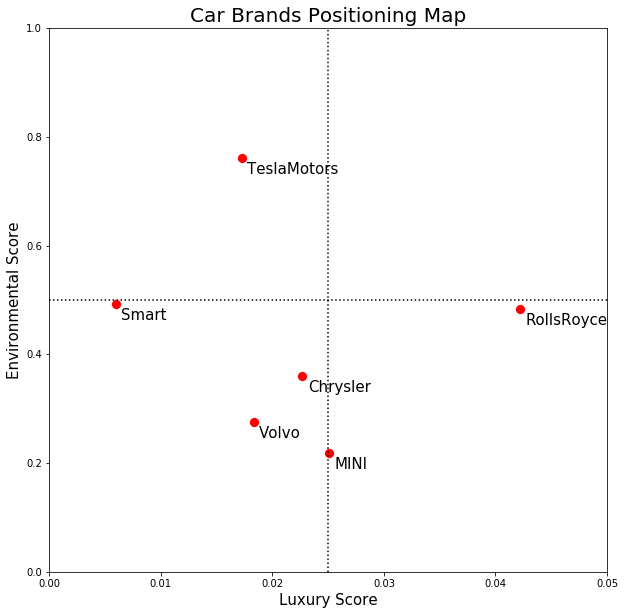

In [7]:
sns.set_context(font_scale=.5)
plt.figure(figsize=(10,10))
plt.title("Car Brands Positioning Map", size=20)
sns.scatterplot("Luxury Score", "Environmental Score", data = final, marker = "o", color = "red", s=100)
plt.xlim(right = 0.05)
plt.xlim(left = 0)
plt.ylim((0, 1))
plt.ylabel("Environmental Score", size=15)
plt.xlabel("Luxury Score", size=15)
plt.hlines(0.5, 0, 1, linestyles="dotted")
plt.vlines(0.025, 0, 1, linestyles="dotted")

c = -1
for i in final['Car Brand'].tolist():
    c += 1
    if i=='smartcarusa':
        i='Smart'
    elif i=='volvocars':
        i='Volvo'
    plt.annotate(s=i,
                 xy=(final["Luxury Score"].loc[c], final["Environmental Score"].loc[c]),
                xytext=(final["Luxury Score"].loc[c]+.0005, final["Environmental Score"].loc[c]-.03), size=15)